In [1]:
!pip install langchain-groq
!pip install langgraph
!pip install neo4j
!pip install pyvis
!pip install -q langchain langchain_experimental openai python-dotenv langchain_openai
!pip install --upgrade openai
!pip install termcolor
!pip install colorama
!pip install --upgrade --quiet opik openai groq
!pip install langchain_chroma
!pip install pypdf
!pip install faiss-cpu
!pip install tiktoken

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Thesis Code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis Code


In [3]:
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_chroma import Chroma
from langchain.chains import create_retrieval_chain, ConversationChain, LLMChain
from langchain.chains.combine_documents import create_stuff_documents_chain
from typing_extensions import Literal
from getpass import getpass
from langgraph.graph import StateGraph, START, END
from langchain.schema import HumanMessage
from langchain_core.tools import tool
from langchain_openai.chat_models.base import BaseChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from IPython.display import display, Image
from langchain_core.utils.function_calling import convert_to_openai_tool
import operator
from typing import Annotated, List, Tuple, TypedDict
from tools import *
import pandas as pd
import re
import json
from iyp import *
import os

In [4]:
# Prompt the user for their API key
groq_api_key = getpass("Please enter your Groq API key: ")

Please enter your Groq API key: ··········


In [5]:
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass("Enter API key for OpenAI: ")

Enter API key for OpenAI: ··········


In [6]:
# Please install OpenAI SDK first: `pip3 install openai`
from openai import OpenAI
deep_seek_key = getpass("Enter API Key for DeepSeek: ")

Enter API Key for DeepSeek: ··········


In [7]:
if not os.environ.get("TAVILY_API_KEY"):
  os.environ["TAVILY_API_KEY"] = getpass("Tavily API key:\n")

Tavily API key:
··········


# **Getting a user's task and decomposing it into a sub-problems**

In [8]:
# Cache the function to load and process PDF documents
def load_and_process_pdfs(pdf_folder_path):
    documents = []
    for folder in os.listdir(pdf_folder_path):
        folder_path = os.path.join(pdf_folder_path, folder)
        # print(folder_path)
        for file in os.listdir(folder_path):
            if file.endswith('.pdf'):
                pdf_path = os.path.join(folder_path, file)
                # print(pdf_path)
                loader = PyPDFLoader(pdf_path)
                documents.extend(loader.load())
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(documents)
    return splits

In [9]:
def extract_json(input_string):
    match = re.search(r'```json\n(.*?)\n```', input_string, re.DOTALL)
    if match:
        try:
            json_data = json.loads(match.group(1))
            return json.dumps(json_data, indent=4)
        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)
            return None
    return None

In [10]:
pdf_folder_path = "Agents/docs"
splits = load_and_process_pdfs(pdf_folder_path)

In [11]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [13]:
# groq_llm = ChatGroq(temperature=0, groq_api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b-specdec")
gpt4o_llm = ChatOpenAI(model="gpt-4o")
# o3_mini_llm = ChatOpenAI(model="o3-mini-2025-1-31")
# deep_seek_RL_llm = BaseChatOpenAI(
#     model='deepseek-reasoner',
#     openai_api_key=deep_seek_key,
#     openai_api_base='https://api.deepseek.com',
#     max_tokens=1024
# )

# deep_seek_chat_llm = BaseChatOpenAI(
#     model='deepseek-chat',
#     openai_api_key=deep_seek_key,
#     openai_api_base='https://api.deepseek.com',
#     max_tokens=1024
# )

In [14]:
task_description_first = '''You are a computer network expert, with expertise on the Internet architecture and BGP protocol,
    who research about solving problems in the Internet network using data.
    You will have to solve a problem in Internet topology and routing Protocols.
    Assume you have an access to the Internet Yellow Pages, which is a knowledge graph of the internet,
    with the following entities and relationships:'''
task_description_second = '''Use the information you got about the Internet Yellow Pages, with the following pieces of
    retrieved information to answer the given question.
    You have to solve the problem while assuming you have an access to the Internet Yellow Pages knowledge graph.
    Assume that the data in the Internet Yellow Pages may be NOISY, so make sure you ask to query the data from multiple databases.
    If the problem is simple - pass it without decompose it into substeps.
    If the problem is complex, erite the steps and the substeps AND ONLY THEM in your answer, WITHOUT ANY ADDITIONAL DATA.
    Let's see some examples of problems which can be solved easily in one Internet Yellow Pages query:'''
task_description_third = '''Remember that you have to include a final step which gives the final answer.
    Take into account that these steps will be coverted into a Cypher code for querying
    the Internet Yellow Pages by another agent (DO NOT DO THAT BY YOURSELF).'''

# **Building the Agent**

**Tools**

In [ ]:
# search_tool = TavilySearchResults(
#     max_results=2,
#     search_depth="advanced",
#     include_answer=True,
#     include_raw_content=False,
#     include_images=False,
# )

In [15]:
# Define tools
@tool
def call_IYP(task:str) -> str:
  '''
    Querying IYP for simple problem
    Args:
      task: The task to be solved
  '''
  return query_iyp(task, gpt4o_llm)

In [16]:
@tool
def call_IHR(task:str) -> str:
  '''
  Querying IHR for simple problem
  Args:
    task: The task to be solved
  '''
  pass

In [17]:
# Augment the LLM with tools
tools = [call_IYP]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = gpt4o_llm.bind_tools(tools)

**State Definition**

**Agnet Architecture**

In [18]:
def task_decomposition(state: MessagesState):
  prompt = PromptTemplate(
        input_variables=["task_description_first", "iyp_entities", "iyp_relationships", "task_description_second",
                         "examples", "task_description_third", "context", "human"],
        template="""
        Task Description_First:{task_description_first}
        Entities:{iyp_entities}
        Relationships:{iyp_relationships}
        Task Description_Second:{task_description_second}
        Examples: {examples}
        Task Description_Third:{task_description_third}
        context:{context}
        human:"{input}"
        """
    )
  question_answer_chain = create_stuff_documents_chain(gpt4o_llm, prompt)
  rag_chain = create_retrieval_chain(retriever, question_answer_chain)
  human_message_content = state["messages"][0].content
  results = rag_chain.invoke(
    {
     "task_description_first": task_description_first,
     "iyp_entities": iyp_entities,
     "iyp_relationships": iyp_relationships,
     "task_description_second": task_description_second,
     "examples": examples,
     "task_description_third": task_description_third,
     "input": human_message_content
     })
  print(results['answer'])
  return {"messages": results['answer']}

In [19]:
# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content='''
                        You are a computing network expert who solves problem on routing, BGP and DNS.
                        You get a problem which may be divided into a sub problems, and you have to solve it.
                        You can call Internet Yellow Pages tools (IYP) for solving the sub problems - depends in your choice.
                        You can ask a query which solve multiple sub-problems at once, or ask for a query for each sub-problem - you need
                        to choose.
                        In the end, you have to make a conclusion and give the final answer to the user according the data you got.
                        You should always think about what to do when choosing the tool to use -
                        Do not use the given tool if you don't need and stop calling the tool if the answer is good enough.
                        If you need to call a tool - write down why you have to do it, and which data do you need.
                        After stop calling the tool - give the final answer
                        Please state explicitly when you reached the final answer.'''
                    )
                ]
                + state["messages"]
            )
        ]
    }

In [20]:
def tool_node(state: dict):
    """Performs the tool call"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [21]:
# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

In [22]:
workflow = StateGraph(MessagesState)

# Decompose the taks to subtasks
workflow.add_node("problem_decomposition", task_decomposition)

# Add the solver step
workflow.add_node("solver",llm_call)

# Add nodes
workflow.add_node("environment", tool_node)

# Summarize
# workflow.add_node("summary", summarization)


workflow.add_edge(START, "problem_decomposition")
workflow.add_edge("problem_decomposition", "solver")
workflow.add_conditional_edges(
    "solver",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
workflow.add_edge("environment", "solver")

app = workflow.compile()

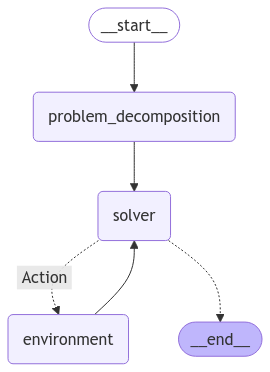

In [23]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# **Using the agent for solving different BGP tasks**

In [24]:
def solve_problem(task):
  # Wrap the task within a HumanMessage
  input_message = HumanMessage(content=task)
  # Pass the HumanMessage to the workflow
  result = app.invoke({'messages': [input_message]})
  print(result['messages'][-1].content)

**AS Classification**

In [25]:
as_classification = "What is the organizational class type of AS1299?"
solve_problem(as_classification)

Steps to determine the organizational class type of AS1299:

1. Query the Internet Yellow Pages knowledge graph to retrieve the node for AS1299 by its `asn` property.
2. Identify any associated `Tag` nodes that categorize AS1299, specifically looking for tags that relate to its organizational class type.
3. Cross-reference the classification with multiple data sources, given that the data may be noisy.
4. Final Step: Collate and summarize the organizational class type for AS1299 based on the categorized tags and the cross-referenced data sources.
content="I acknowledge the steps you've provided to determine the organizational class type of AS1299. The process involves querying the Internet Yellow Pages knowledge graph to gather information about AS1299, specifically focusing on tags that categorize it. However, this requires cross-referencing with multiple data sources due to potential data noise.\n\nI will query the Internet Yellow Pages (IYP) regarding AS1299 and its organizational c

**IP Geolocation**

In [26]:
ip_geo = "What is the geolocation of of the ip range 109.67.160.0/20?"
solve_problem(ip_geo)

1. **Identify IP Prefix**: Use the given IP range to locate the specific prefix node in the Internet Yellow Pages.
   - Query for a `Prefix` node where the `prefix` property matches `109.67.160.0/20`.

2. **Find Associated IPs**: Once the specific prefix is identified, find the IP nodes that are associated with this prefix.
   - Query for `IP` nodes that have a `PART_OF` relationship with the identified `Prefix`.

3. **Geolocation Investigation**: In order to determine the geolocation, check the `RESOLVES_TO` relationships of these `IP` nodes to any `HostName`.
   - Investigate if any of these hostnames include location information by looking at naming conventions or additional tags attached to these nodes.

4. **Country and Region Association**: Retrieve any `Country` or `Region` nodes related to these `IP` nodes.
   - Query for relationships indicating such connections, which might include `COUNTRY` or location-based `TAG` relationships, providing country or regional data.

5. **Use 

In [27]:
as_geo = "What is the geolocation of of as6810?"
solve_problem(as_geo)

### Steps to Determine the Geolocation of AS6810

1. **Access the Knowledge Graph:**
   - Ensure access to the Internet Yellow Pages knowledge graph that contains detailed geolocation and Autonomous System (AS) data.

2. **Identify the Required Entity:**
   - Target the AS node with ASN 6810 in the knowledge graph.
   - Use the `AS` entity type and `asn` property to locate AS6810.

3. **Fetch Associated Geolocation Data:**
   - Query for the `LOCATED_IN` relationship which links the AS to its associated `Country` or specific geographic location data.

4. **Analyze Reverse DNS Data:**
   - If the `LOCATED_IN` relationship does not provide sufficient granularity, examine reverse DNS hostnames related to AS6810 for city or region hints.
   - Leverage any additional geolocation datasets linked within the graph through relationships like `COUNTRY` or with `Tag` classifications for location hints.

5. **Correlate and Validate with External Sources:**
   - Cross-reference findings with datase

**AS relationship inferring**

In [28]:
as_rel = "What is the relationship between AS6810 and AS2914?"
solve_problem(as_rel)

1. **Identify the Entities**: Determine the nodes corresponding to AS6810 and AS2914 in the Internet Yellow Pages knowledge graph.
   
2. **Identify the Relationships**: Query to find any direct relationships between AS6810 and AS2914. Check for the following possibilities:
   - **PEERS_WITH**: See if they have a peering relationship.
   - **DEPENDS_ON**: Check if one AS depends on the other.
   - **SIBLING_OF**: Determine if they have a sibling relationship.
   - **PROVIDER-CUSTOMER** (custom implementation based on data): This would typically fall under DEPENDS_ON if one AS is a provider of the other.
   
3. **Verify the Relationship**: Use available attributes to further confirm the type of relationship (e.g., looking for reference names that might indicate the source of relationship data).
   
4. **Return Results**: Output the type and relevant details of the relationship(s) found between AS6810 and AS2914.
   
5. **Ensure Data Consistency**: Validate the identified relationship by

In [30]:
as_rel = "What is the relationship between AS6810 and AS8048?" #AS6810 - Bezeq, AS8048 - CANTV Servicios, Venezuela
solve_problem(as_rel)

Steps to determine the relationship between AS6810 and AS8048 using the Internet Yellow Pages:

1. Query the Internet Yellow Pages to check for a **PEERS_WITH** relationship between AS6810 and AS8048.
2. Check for a **DEPENDS_ON** relationship to find if AS6810 depends on AS8048 or vice versa.
3. Look for a **SIBLING_OF** relationship to see if these entities are part of the same organization.
4. Finally, provide the type of relationship found between AS6810 and AS8048 as the answer.
content="We will need to make multiple queries to the Internet Yellow Pages (IYP) to determine the relationship between AS6810 and AS8048. Specifically, we'll need to check for the following possible relationships: **PEERS_WITH**, **DEPENDS_ON**, and **SIBLING_OF**.\n\nHere's how we'll proceed:\n1. Query to check for the **PEERS_WITH** relationship.\n2. Query to check for the **DEPENDS_ON** relationship.\n3. Query to check for the **SIBLING_OF** relationship.\n\nWe'll perform these queries simultaneously t

In [31]:
as_rel = "List 5 upstreams for AS8048."
solve_problem(as_rel)

Steps to solve the problem:

1. Identify the AS node corresponding to AS8048.
   - Query the knowledge graph to find AS8048.

2. Find the upstream ASes for AS8048.
   - Check for `DEPENDS_ON` relationships from AS8048 directed to other AS nodes.

3. Aggregate and limit the results to the first 5 upstream ASes.

4. Final step: Provide the list of 5 identified upstream ASes for AS8048.
content="To find the upstreams for AS8048, it's necessary to access real-time data or databases that track autonomous systems' relationships, such as the BGP tables. Since I don't have direct access to such BGP tables, I'll use the Internet Yellow Pages (IYP) to perform the querying.\n\nI will call the IYP tool to find the upstreams for AS8048. The task is to identify the upstream ASes that AS8048 depends on.\n\nHere is the step I will take:\n\n- Utilize the Internet Yellow Pages tool to find the upstream providers for AS8048.\n\nI will proceed with calling the IYP tool for this specific query." additional

In [33]:
as_rel = "List the top 5 peers for AS6810."
solve_problem(as_rel)

Steps to solve the problem:

1. **Identify the AS Node:**
   - Locate the AS node with the ASN 6810 in the graph.

2. **Find PEERS_WITH Relationships:**
   - Query for all `PEERS_WITH` relationships connected to the AS6810 node.
   
3. **Retrieve Peers:**
   - Retrieve the AS nodes that have a `PEERS_WITH` relationship with AS6810.
   
4. **Rank Peers:**
   - Rank these peer AS nodes based on a relevant metric, such as the number of routes exchanged or any available ranking score in the graph that might indicate the significance of the peer relationship.

5. **Select Top 5 Peers:**
   - Select the top 5 peers based on the ranking from Step 4.

6. **Final Step - Provide the Result:**
   - Return the list of these top 5 AS peers for AS6810.
content="To solve the problem of listing the top 5 peers for AS6810, I will utilize the IYP tool to identify the peers based on the necessary criteria. This involves querying for the peers of AS6810 and ranking them based on connectivity metrics or an



> Entering new AgentExecutor chain...
The table presents peering information with columns for PeerASN and an unspecified Score.

1. PeerASN 263009: This peer has no score listed.
2. PeerASN 49544: This peer also has no score listed.
3. PeerASN 6424: As with the previous entries, there's no score provided.
4. PeerASN 6762: This peer does not have a score listed.
5. PeerASN 1267: Similarly, no score is shown for this peer.

Conclusion: All of the listed peers do not have scores, making it impossible to determine the top 5 peers for AS6810 based on connectivity or significance scores. Without the score data, it is not possible to rank these ASNs.

> Finished chain.
content="The query result from the Internet Yellow Pages (IYP) reveals the following peers for AS6810, but without any specific ranking scores or metrics:\n\n1. PeerASN 263009\n2. PeerASN 49544\n3. PeerASN 6424\n4. PeerASN 6762\n5. PeerASN 1267\n\nUnfortunately, without any significance scores or specific rankings associated 

**Bogon IP classification**

In [34]:
bogon_detection = "Determine if the following prefix is bogon: 23.155.163.0/24." #Yes
solve_problem(bogon_detection)

Steps to determine if the prefix 23.155.163.0/24 is a bogon:

1. **Query for Allocation Status:**
   - Check if the prefix 23.155.163.0/24 is allocated to a Regional Internet Registry (RIR) by IANA.
   - Reference the `ASSIGNED` and `AVAILABLE` relationships in the Internet Yellow Pages to determine if this prefix is allocated and assigned.

2. **Prefix Length Validation:**
   - Verify if the prefix length is valid. A prefix length of 24 is within the valid range (8-32), so it should not be marked as a bogon based on length alone.
   - This step is noted to ensure that length doesn't falsely classify a prefix as a bogon.

3. **Check Bogon List:**
   - Look up the prefix in a known bogon list for the AS of interest, as bogon lists can vary. This can be retrieved through `CATEGORIZED` relationships if classifications exist in the knowledge graph.
   - Specifically check for `Tag` nodes that may relate to "bogon" classifications.

4. **Final Decision:**
   - Determine if the prefix is cat



> Entering new AgentExecutor chain...
The table provided is very minimal and does not contain any data rows. It has two column headers: "pfx" and "opaque". 

Given the prefix 23.155.163.0/24, I am unable to determine the allocation status with IANA based on the table since it contains no data. Therefore, the absence of data in the table does not allow for any conclusions to be drawn regarding the prefix 23.155.163.0/24 allocation status.

> Finished chain.


> Entering new AgentExecutor chain...
The table provided consists of two columns: "pfx" and "tag". However, there is no data presented in the table; it appears to be empty as only the headers of the table are shown with no rows of data.

Conclusion: Since the table is empty and does not contain any information about prefixes, the query regarding whether the prefix 23.155.163.0/24 is in any known bogon lists cannot be answered using this table. Therefore, based on the available data, we cannot determine if 23.155.163.0/24 is in an

**Valley free validation**

In [35]:
vf_validation = "Determine if the following path is valley-free: 6810 6453 49600 210123 6939." #No
solve_problem(vf_validation)

**Steps to Determine if the Path is Valley-Free:**

1. **Set Up the AS Path:**
   - Path: 6810 6453 49600 210123 6939.

2. **Identify the AS Relationships:**
   - Query the Internet Yellow Pages (IYP) to identify relationships between each pair of consecutive AS numbers in the path:
     - AS 6810 to AS 6453.
     - AS 6453 to AS 49600.
     - AS 49600 to AS 210123.
     - AS 210123 to AS 6939.

3. **Determine the Relationship Type for Each Segment:**
   - For each pair of ASes, determine if the relationship is:
     - Provider-to-Customer (p2c)
     - Customer-to-Provider (c2p)
     - Peer-to-Peer (p2p)
     - Sibling-to-Sibling

4. **Evaluate Valley-Free Criteria:**
   - A valley-free path is typically composed of:
     - An uphill segment of p2c or sibling links, followed by one optional p2p link, followed by a downhill segment of c2p or sibling links.
   - Ensure that:
     - There is no p2c link followed by a c2p link (creating a valley).
     - Peer links do not follow provider l

**BGP Hijacking detection**

In [ ]:
bgp_validation = "Determine if the following path is hijacked: 6810 1299 4531 6939 2497." #Yes
solve_problem(bgp_validation)

# **Problems from [IYP paper](https://dl.acm.org/doi/pdf/10.1145/3646547.3688444)**

In [ ]:
dns_zone_cut = "Describe the DNS zone cut for 'nytimes.com' DomainName."
solve_problem(dns_zone_cut)

In [ ]:
cern_rpki_valid_prefixes = '''find the popular hostnames corresponding to prefixes originated by ASes managed by CERN and
that are RPKI valid.'''
solve_problem(cern_rpki_valid_prefixes)

In [ ]:
tranco_1m = '''Resolve IP addresses from the Tranco Top 1 million list and count the number of RPKI invalid prefixes.'''
solve_problem(tranco_1m)

In [ ]:
netherlands_domains = "Query getting the top 5 domains by visiting data, which are hosted in the Netherlands."
solve_problem(netherlands_domains)